# Calculate SYBA and other scores

## Requirments
We compared SYBA with SAScore (https://github.com/rdkit/rdkit/tree/master/Contrib/SA_Score), SCScore (https://github.com/connorcoley/scscore) and random forest trained within scikit-learn framework so these packages have to be installed. Complexity metrics are calculated from Nonpher package (https://github.com/lich-uct/nonpher). Cheminformatics library RDKit is also needed for all models (SYBA, SAScore, SCScore, RF) and complexities from Nonpher. To run this notebook, Jupyter has to be installed.

To obtain SAScore and SCScore, you may to download/clone and add folder with python files to PYTHONPATH before running Jupyter:
```bash
# for Nonpher installation with conda
conda install -c rdkit -c lich nonpher
conda install scikit-learn jupyter

# PATH_TO_SASCORE is path to folder, where is sascorer.py file
# PATH_TO_SCSCORE is path to cloned SCScore folder from github
export PYTHONPATH=PATH_TO_SASCORE:PATH_TO_SCSCORE:$PYTHONPATH
jupyter notebook
```

In [1]:
from sklearn.externals import joblib
from rdkit.Chem.Draw import IPythonConsole #Needed to show molecules+
from rdkit.Chem import Draw
from rdkit.Chem import AllChem as Chem
import gzip
import os

In [2]:
from syba.syba import SybaClassifier, SmiMolSupplier
from scscore.standalone_model_numpy import SCScorer
import sascorer as sa
from sklearn.ensemble import RandomForestClassifier

# needed to calculate complexities
from nonpher import complex_lib as cmplx

## How models predict scores or classes

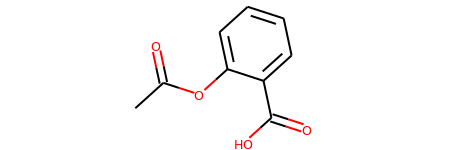

In [3]:
smi = "O=C(C)Oc1ccccc1C(=O)O"
mol = Chem.MolFromSmiles(smi)
Chem.MolFromSmiles(smi)

## SYBA

In [4]:
syba = SybaClassifier()
syba.fitDefaultScore()
syba.predict(smi)

15.47612958023674

## SAScore

In [5]:
sa.calculateScore(mol)

1.580039750008826

## SCScore

In [6]:
scscore = SCScorer()
scscore.restore()
scscore.get_score_from_smi(smi)[1]

Restored variables from /home/milan/workspace/scscore/models/full_reaxys_model_1024bool/model.ckpt-10654.as_numpy.pickle


1.5930637909666663

## Random forest

Random forest classifier is trained on 1024-bit ECFP4-like fingerprints (model can't be shared within this repository due to its enormous size of 1.6GB)

In [7]:
nBits = 1024
if not os.path.exists("../data/rf.pkl"):
    syn_fps = [Chem.GetMorganFingerprintAsBitVect(spls[0],2,nBits=nBits) for spls in SmiMolSupplier(gzip.open("../data/structures_2.csv.gz", mode="rt"), header=True, smi_col=1)]
    syn_classes = [1 for x in range(len(syn_fps))]
    non_fps = [Chem.GetMorganFingerprintAsBitVect(spls[0],2,nBits=nBits) for spls in SmiMolSupplier(gzip.open("../data/structures_1.csv.gz", mode="rt"), header=True, smi_col=2)]
    non_classes = [0 for x in range(len(non_fps))]
    fps = syn_fps + non_fps
    classes = syn_classes + non_classes

    clf = RandomForestClassifier(n_estimators=100)
    clf.fit(fps, classes)
    joblib.dump(clf, "../data/rf.pkl")
else:
    clf = joblib.load("../data/rf.pkl")
    
fp = Chem.GetMorganFingerprintAsBitVect(mol,2,nBits=nBits)
clf.predict([fp])[0], clf.predict_proba([fp])[0]

(1, array([0., 1.]))

## Complexities

In [8]:
cmplx.BertzCT(mol), cmplx.WhitlockCT(mol), cmplx.BaroneCT(mol), cmplx.SMCM(mol)

(343.2228677267164, 12, 255, 20.189999999999998)

## Prepare result files with calculated scores: SYBA, SAScore and SCScore
### Test files

In [9]:
inpath = "../data/"
outpath = "../out/"
files = ["test_set_mc_es.csv", "test_set_mc_hs.csv", "test_set_cp_es.csv", "test_set_cp_hs.csv"]
for f in files:
    with open(inpath+f) as inp, open(outpath+f, "w") as out:
        header = inp.readline().strip()
        out.write(header)
        out.write(",syba,sascore,scscore,rf_class,rf_prob,bertz,whitlock,barone,smcm\n")
        for line in inp:
            idx, smi, atoms = line.strip().split(",")
            mol = Chem.MolFromSmiles(smi)
            fp = Chem.GetMorganFingerprintAsBitVect(mol,2,nBits=nBits)
            out.write("{},{},{},{},{},{},{},{},".format(idx, smi, atoms, syba.predict(smi), sa.calculateScore(mol), scscore.get_score_from_smi(smi)[1], clf.predict([fp])[0], clf.predict_proba([fp])[0][1]))
            out.write("{},{},{},{}\n".format(cmplx.BertzCT(mol), cmplx.WhitlockCT(mol), cmplx.BaroneCT(mol), cmplx.SMCM(mol)))

Unsupported atom #14
Unsupported atom #14


### Training files
Training compounds are in pairs: ZINC compound as ES and virtual compound generated with Nonpher as HS. This code runs for few hours

In [10]:
inpath = "../data/"
outpath = "../out/"
#          INP_FILENAME,      SMI_COL,  OUT_FILENAME
files = [("structures_1.csv.gz", 2, "train_set_hs.csv"), ("structures_2.csv.gz", 1, "train_set_es.csv")]
for f, col, out_filename in files:
    with gzip.open(inpath+f, mode="rt") as inp, open(outpath+out_filename, "w") as out:
        header = inp.readline().strip()
        out.write("idx,smiles,atoms,syba,sascore,scscore,rf_class,rf_prob,bertz,whitlock,barone,smcm\n")
        for line in inp:
            spls = line.strip().split(",")
            idx, smi = spls[0], spls[col]
            mol = Chem.MolFromSmiles(smi)
            fp = Chem.GetMorganFingerprintAsBitVect(mol,2,nBits=nBits)
            out.write("{},{},{},{},{},{},{},{},".format(idx, smi, mol.GetNumHeavyAtoms(), syba.predict(smi), sa.calculateScore(mol), scscore.get_score_from_smi(smi)[1], clf.predict([fp])[0], clf.predict_proba([fp])[0][1]))
            out.write("{},{},{},{}\n".format(cmplx.BertzCT(mol), cmplx.WhitlockCT(mol), cmplx.BaroneCT(mol), cmplx.SMCM(mol)))

### Synthetic ways from SCScore [http://dx.doi.org/10.1021/acs.jcim.7b00622]

In [12]:
inpath = "../data/"
outpath = "../out/"
files = ["smiles_fig7.csv"]
for f in files:
    with open(inpath+f) as inp, open(outpath+f, "w") as out:
        header = inp.readline().strip()
        out.write(header)
        out.write(",atoms,syba,sascore,scscore,rf_class,rf_prob,bertz,whitlock,barone,smcm\n")
        for line in inp:
            name, idx, smi = line.strip().split(",")
            mol = Chem.MolFromSmiles(smi)
            fp = Chem.GetMorganFingerprintAsBitVect(mol,2,nBits=nBits)
            out.write("{},{},{},{},{},{},{},{},{},".format(name, idx, smi, mol.GetNumHeavyAtoms(), syba.predict(smi), sa.calculateScore(mol), scscore.get_score_from_smi(smi)[1], clf.predict([fp])[0], clf.predict_proba([fp])[0][1]))
            out.write("{},{},{},{}\n".format(cmplx.BertzCT(mol), cmplx.WhitlockCT(mol), cmplx.BaroneCT(mol), cmplx.SMCM(mol)))

Unsupported atom #50
Unsupported atom #11
Unsupported atom #11
Unsupported atom #11
Unsupported atom #11
